In [2]:
'''Remember to make sure to update the Variables file.
Also please reload the kernal before running this to update the Variables'''

import BayesianOptimiser.Variables_BO as Variables
import BayesianOptimiser.BOAnalysis as Analysis
# Replace with the relevant csv file
csv_path = '/work4/clf/david/Bayesian/OutputsBO/Outputs_3/Results.csv'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import heapq 

In [14]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Extract the Y data from the DataFrame and append it to the current Y data
Y_data = np.array(df['Result'].values)

# Calculate the new length of the Y data array after updating
csv_data_length = np.shape(Y_data)[0]

# Initialize a zero array for the new X data with the correct shape
X_data = np.array(np.zeros((csv_data_length, len(Variables.bounds))))

# Loop over each row of the newly added data and each column (each dimension of X)
for i in range(csv_data_length):
    for k in range(len(Variables.bounds)):
        # Fill in the X data with the values from the DataFrame
        X_data[i][k] = df[f'X{k}'][i]

In [3]:
"""
Get the manually optimised baseline result to compare against.
"""

simulation_CDF_file = '/work4/clf/jordanlee/Hyades/SummerProject/ExampleHotspot/Data/TestInputDeck.cdf'

# Pull important values from the simulation
gain_data = Analysis.Gain(simulation_CDF_file)
CR_data = Analysis.ConvergenceRatio(simulation_CDF_file)
IFAR_data = Analysis.IFAR(simulation_CDF_file)
velocity_data = Analysis.ImplosionVelocity(simulation_CDF_file)

gain = gain_data[0]
CR = np.max(CR_data[0])
IFAR = IFAR_data[0][IFAR_data[1]]
velocity = abs(min(velocity_data[0]))
parametric_limit = Analysis.LaserProfile(simulation_CDF_file)[2]

def GetMultiplier (x, X_cutoff, halve_width=False):
    """
    Calculate the multiplier based on the value and cutoff.

    This helper function computes a multiplier using a logistic function, 
    which is used to reduce the effective gain if certain conditions are met.

    Parameters:
    - X (float): The value of the metric (e.g., CR, IFAR).
    - X_cutoff (float): The cutoff value beyond which the multiplier reduces the gain.

    Returns:
    - float: The multiplier to be applied.
    """
    if halve_width:
        c = 2
    else:
        c = 1

    frac_x = (x - X_cutoff)/(X_cutoff)
    a = 0.9644
    b = 52
    return (1/a)*(1 - (1/(1 + np.exp(-(c*b*frac_x - 3.3)))))


if CR > 16:
    CR_multiplier = GetMultiplier(CR, 16)
else:
    CR_multiplier = 1

if IFAR > 30:
    IFAR_multiplier = GetMultiplier(IFAR, 30)
else:
    IFAR_multiplier = 1

if velocity > 400:
    velocity_multiplier = GetMultiplier(velocity, 400, halve_width=True)
else:
    velocity_multiplier = 1

if parametric_limit > 1e14:
    parametric_limit_multiplier = GetMultiplier(parametric_limit, 1e14)
else:
    parametric_limit_multiplier = 1

# Combine all multipliers into a single value. This is where instability is factored into the loss function.
result = gain * CR_multiplier * IFAR_multiplier * velocity_multiplier * parametric_limit_multiplier

print(result)

0.23640412833269675


Text(0.5, 0, 'Simulation Number')

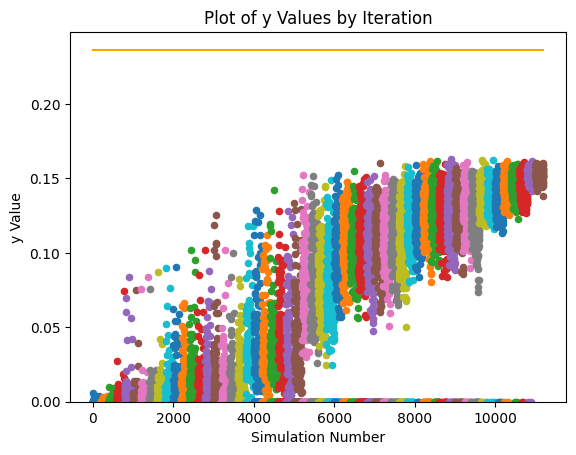

In [16]:
'''If something is not working in this plot, it could well be that the Variables have not updated. Try restarting the kernal.'''

# Read the csv file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Extract the Y data from the DataFrame and append it to the current Y data
y_data = np.array(df['Result'].values)

# Plotting the baseline for comparison
plt.plot([0, len(y_data)], [result, result], color='orange')

# Step 2: Group the values by iteration numbers
grouped = df.groupby('Iteration')['Result'].apply(list)

# Convert the grouped object into a dictionary of arrays
split_arrays = {iteration: np.array(values) for iteration, values in grouped.items()}

simulation_number_counter=0

for i in range(len(split_arrays)):
    # Generate a range of simulation numbers for this batch of values
    simulation_numbers = np.arange(simulation_number_counter, simulation_number_counter + len(split_arrays[i]))
    plt.scatter(simulation_numbers, split_arrays[i], s=20)

    # Update the counter for the next batch
    simulation_number_counter += len(split_arrays[i])

# Set the lower limit of the y-axis to 0 while leaving the upper limit unchanged
plt.ylim(0,)

plt.title('Plot of y Values by Iteration')
plt.ylabel('y Value')
plt.xlabel('Simulation Number')

In [17]:
# Find the indices of the 5 largest Y values
largest_indices = heapq.nlargest(5, range(len(y_data)), key=y_data.__getitem__)
# Retrieve the actual Y values for these indices
largest_values = largest_values = [y_data[i] for i in largest_indices]

# Sort the indices and values into value order
sorted_indices_and_values = sorted(zip(largest_indices, largest_values), key=lambda x: x[1], reverse=True)

# Unzip the sorted pairs back into separate lists of indices and values
sorted_indices, sorted_values = zip(*sorted_indices_and_values)

# Print the Y values and indices of the 5 largest values
print("Y value and indices of the 5 largest values:")
for i in range(len(largest_indices)):
    print(sorted_values[i], sorted_indices[i])

Y value and indices of the 5 largest values:
0.1632111705336495 8911
0.1625068068234487 9669
0.1621926807527965 9946
0.1619718192525561 10290
0.1618307517903445 8382


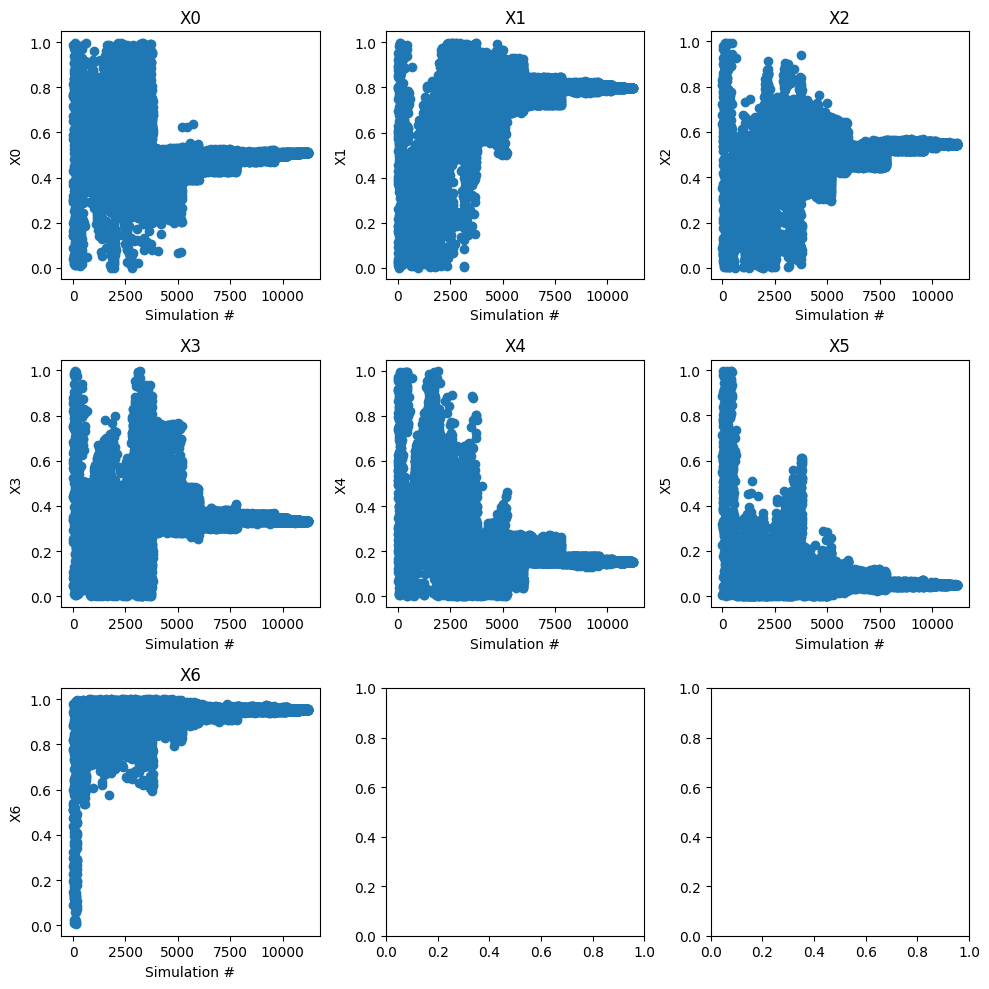

In [19]:
"""
Evolution of each parameter
"""

COLUMN_NUMBER = 3

# Create a figure and a set of subplots
fig, ax = plt.subplots(nrows=int(np.ceil(len(X_data[0]) / COLUMN_NUMBER)), ncols=COLUMN_NUMBER, figsize=(10, 10))

# Loop through each parameter in X_data and make a labelled scatter plot for each
for k in range(len(X_data[0])):
    ax[k//COLUMN_NUMBER, k%COLUMN_NUMBER].scatter(range(len(X_data)), X_data[:, k])
    ax[k//COLUMN_NUMBER, k%COLUMN_NUMBER].set_ylabel('X%i' %k)
    ax[k//COLUMN_NUMBER, k%COLUMN_NUMBER].set_xlabel('Simulation #')
    ax[k//COLUMN_NUMBER, k%COLUMN_NUMBER].title.set_text('X%i' %k)

# Adjust layout to prevent overlap
plt.tight_layout()   

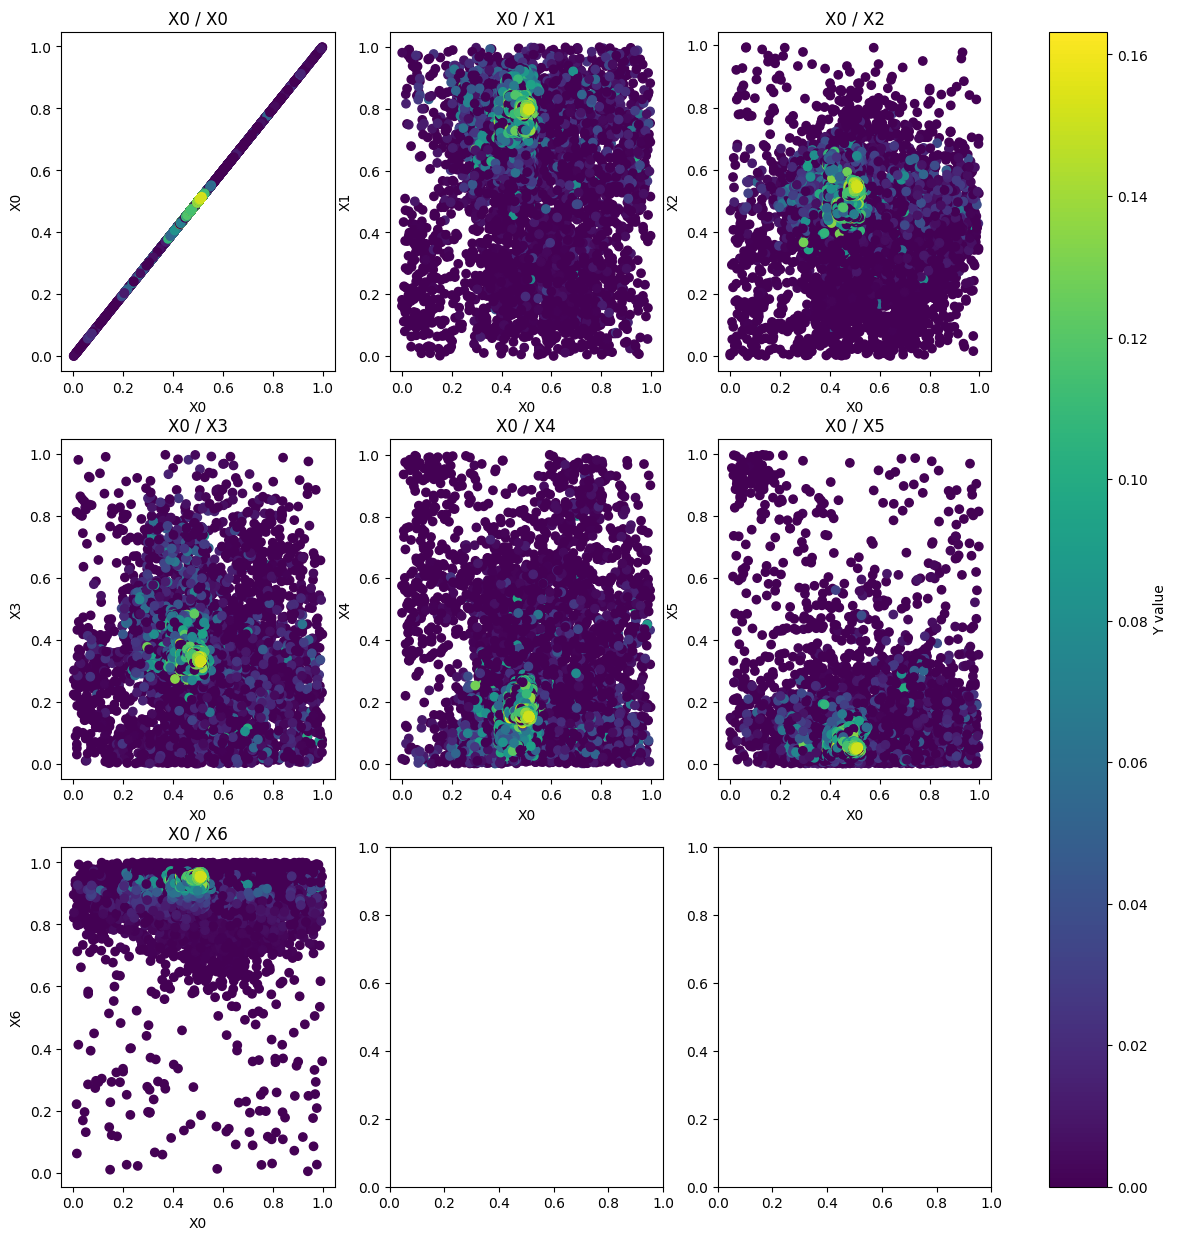

In [20]:
"""
X[i] against X[0] using colour mapping to indicate Y values
"""

COLUMN_NUMBER = 3

# Create a figure and a set of subplots
fig, ax = plt.subplots(nrows=int(np.ceil(len(X_data[0]) / COLUMN_NUMBER)), ncols=COLUMN_NUMBER, figsize=(15, 15))

# Create a scatter plot for each parameter against X[0], using Y_data for colour
for k in range(len(X_data[0])):
    scatter = ax[k//COLUMN_NUMBER, k%COLUMN_NUMBER].scatter(X_data[:, 0], X_data[:, k], c=Y_data, cmap='viridis')
    ax[k//COLUMN_NUMBER, k%COLUMN_NUMBER].set_ylabel('X%i' %k)
    ax[k//COLUMN_NUMBER, k%COLUMN_NUMBER].set_xlabel('X0')
    ax[k//COLUMN_NUMBER, k%COLUMN_NUMBER].title.set_text('X0 / X%i' %k)

# Add a colourbar to the figure
fig.colorbar(scatter, ax=ax.ravel().tolist(), label='Y value')

plt.show()

In [9]:
import numpy as np

# Example Y_data array (length not necessarily divisible by Current_Number_Iterations)
Y_data = np.arange(105)  # Example data, replace with your actual array
Current_Number_Iterations = 10  # Example number of iterations

# Split Y_data into nearly equal-sized sub-arrays
Iteration_Y = np.array_split(Y_data, Current_Number_Iterations)

# Access a specific iteration's Y data
print("Iteration 0 Y data:", Iteration_Y[0])  # Access the first split

Iteration 0 Y data: [ 0  1  2  3  4  5  6  7  8  9 10]
